<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ANN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [29]:
!pip install -U scikit-learn

In [30]:
from sklearn.metrics import mean_absolute_percentage_error

In [31]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [32]:
df = pd.read_csv("airline_passengers.csv",index_col = 'Month',parse_dates = True)

In [33]:
df['LogPassengers'] = np.log(df['Passengers'])

In [34]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [46]:
#boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [47]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [48]:
#Make supervised dataset
series = df['DiffLogPassengers'].to_numpy()[1:]

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t : t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)

print("X shape : ",X.shape," Y shape: ",Y.shape)

X shape :  (133, 10)  Y shape:  (133,)


In [49]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [50]:
#Basic ANN

#Input layer
i = Input(shape = (T,))

#First hidden layer
x = Dense(32,activation = 'relu')(i)

#Final output layer
x = Dense(1)(x)

model = Model(i,x)

In [51]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = 'mae'
)

In [52]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 100,
    validation_data = (XTest,YTest)
)

Epoch 1/100
4/4 [==============================] - 1s 78ms/step - loss: 0.0162 - mae: 0.1043 - val_loss: 0.0142 - val_mae: 0.0949
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0143 - mae: 0.0975 - val_loss: 0.0133 - val_mae: 0.0916
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0129 - mae: 0.0928 - val_loss: 0.0126 - val_mae: 0.0893
Epoch 4/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0118 - mae: 0.0895 - val_loss: 0.0119 - val_mae: 0.0869
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0106 - mae: 0.0854 - val_loss: 0.0112 - val_mae: 0.0849
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0097 - mae: 0.0820 - val_loss: 0.0105 - val_mae: 0.0827
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0088 - mae: 0.0787 - val_loss: 0.0098 - val_mae: 0.0805
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0081 - mae: 0.07

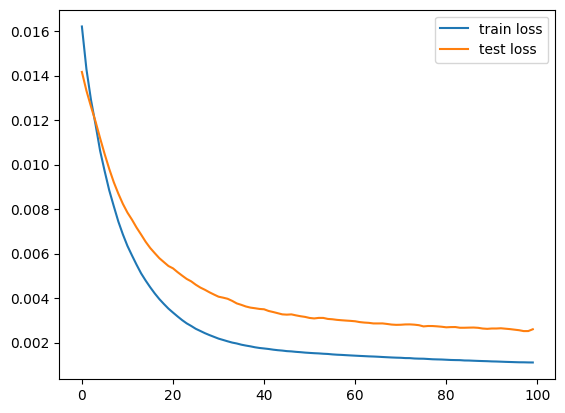

In [53]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [72]:
#First T+1 values are not predictable
train_idx[:T+1] = False

In [73]:
PTrain = model.predict(XTrain).flatten()
PTest = model.predict(XTest).flatten()

1/1 [==============================] - 0s 25ms/step


In [74]:
df.loc[train_idx,'Diff ANN Train Prediction'] = PTrain
df.loc[test_idx,'Diff ANN Test Prediction'] = PTest

In [75]:
df.head()

,Passengers,LogPassengers,DiffLogPassengers,Diff ANN Train Prediction,Diff ANN Test Prediction
Month,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,NaN,NaN
1949-03-01,132,4.882802,0.112117,NaN,NaN
1949-04-01,129,4.859812,-0.022990,NaN,NaN
1949-05-01,121,4.795791,-0.064022,NaN,NaN


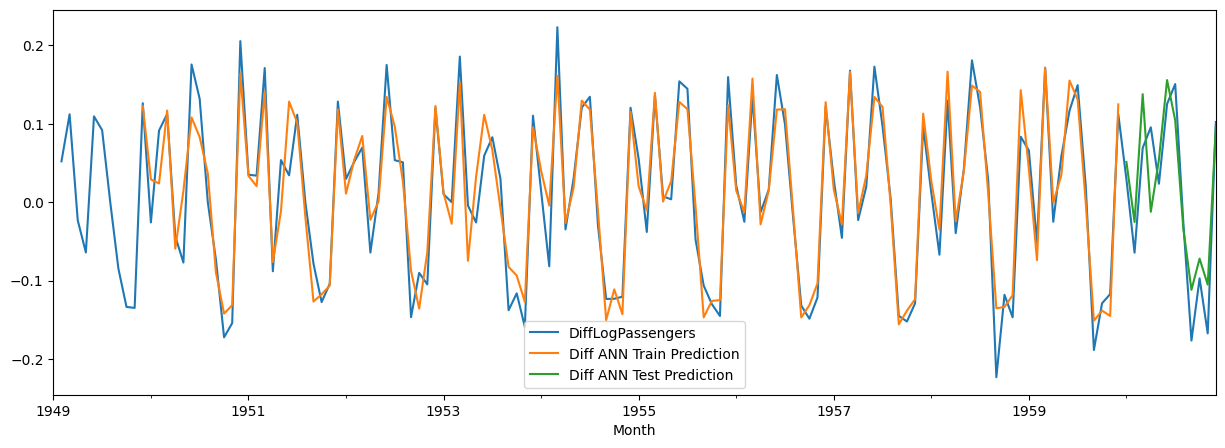

In [66]:
cols = [
    'DiffLogPassengers',
    'Diff ANN Train Prediction',
    'Diff ANN Test Prediction'
]
df[cols].plot(figsize = (15,5));

In [79]:
df['ShiftLogpassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogpassengers']

In [80]:
#Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [83]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

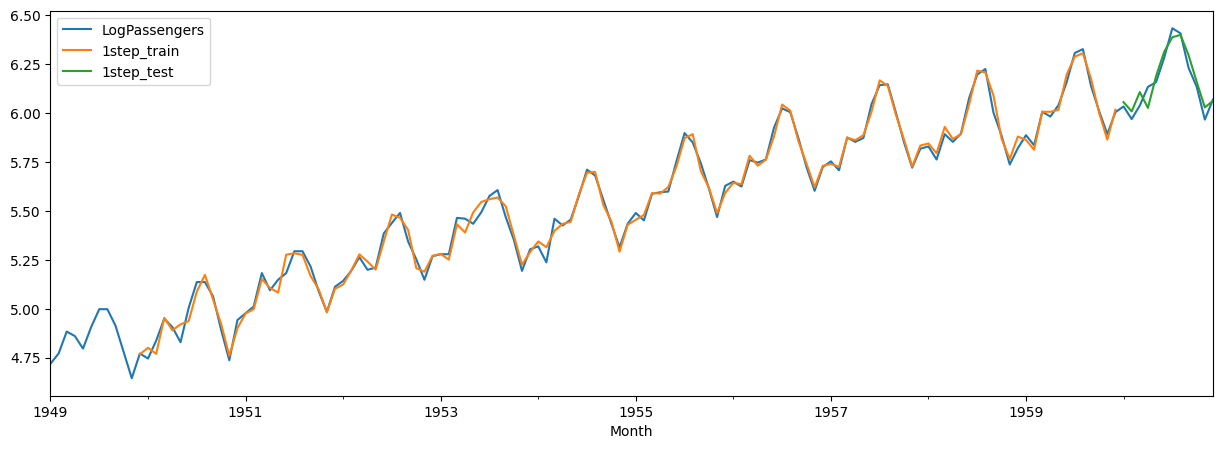

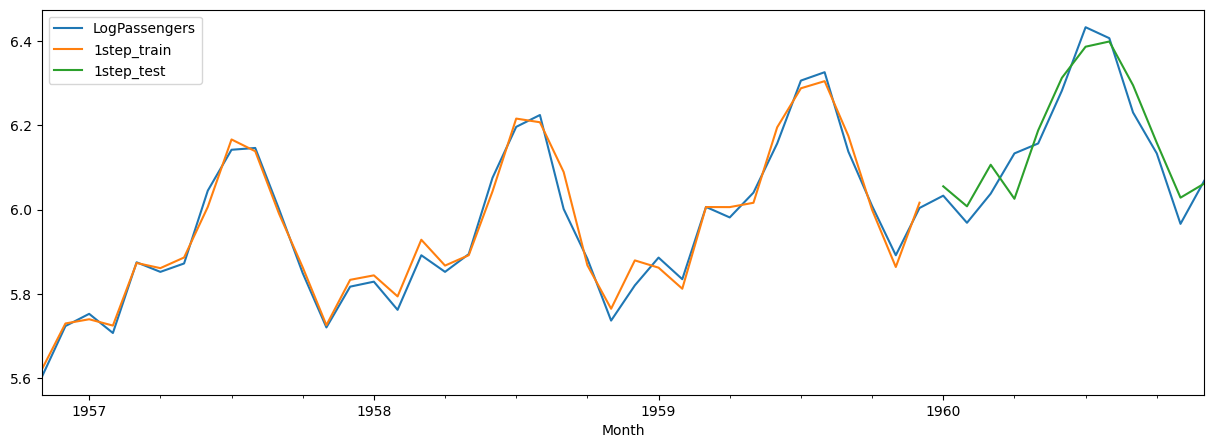

In [85]:
cols = [
    'LogPassengers',
    '1step_train',
    '1step_test'
]

df[cols].plot(figsize = (15,5))
df.iloc[-50:][cols].plot(figsize = (15,5));

In [ ]:
#multi-step forecast
multistep_predictions = []

#first test input
last_x = XTest[0]

while len(multistep_predictions) < NTest:
  p = model.predict(last_x.reshape(1,-1))[0]

  #Update the prediction list
  multistep_predictions.append(p)

  #Make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

In [87]:
#Save multi-step forecast to dataframe
df.loc[test_idx,'multistep'] = last_train + np.cumsum(multistep_predictions)

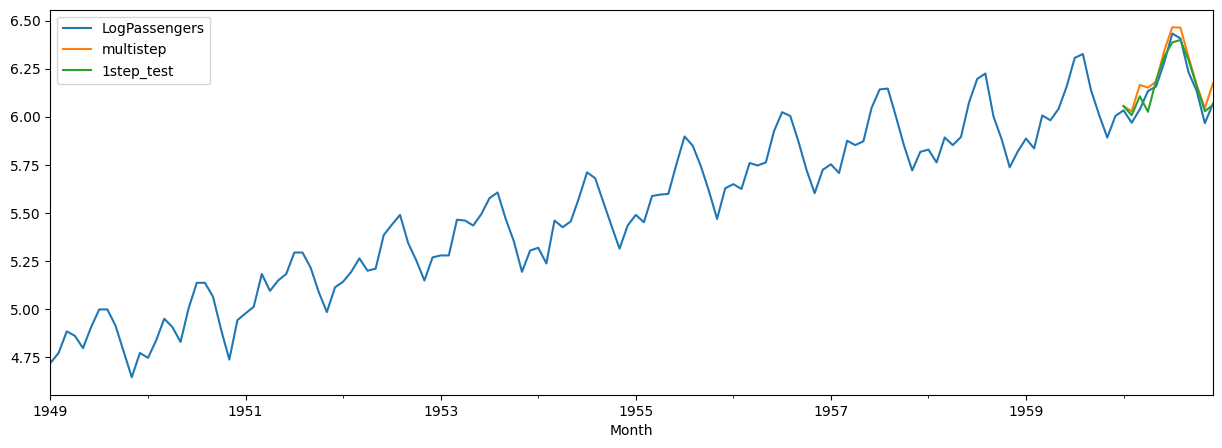

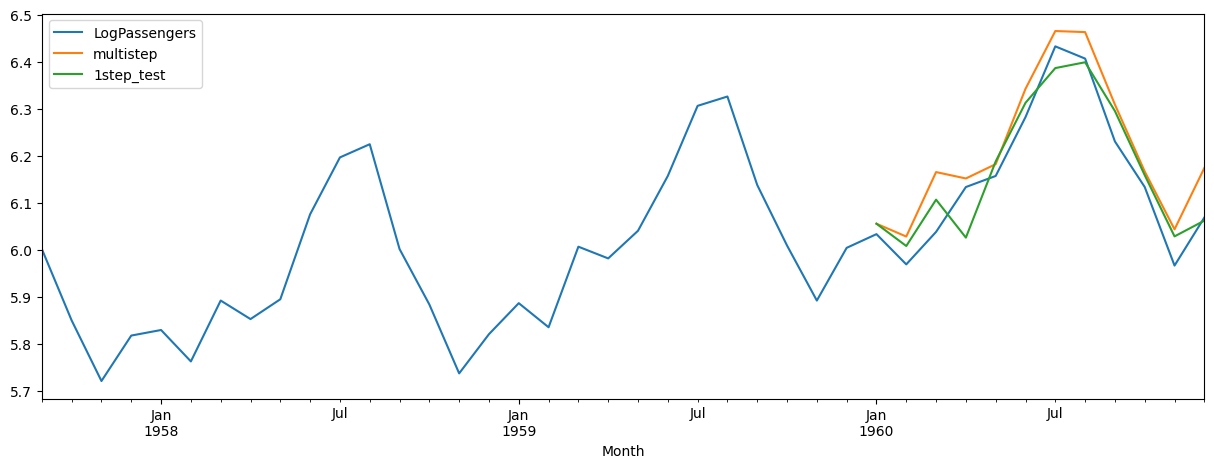

In [89]:
#Plot 1-step and multi-step forecast
cols = [
    'LogPassengers',
    'multistep',
    '1step_test'
]
df[cols].plot(figsize = (15,5))
df.iloc[-40:][cols].plot(figsize = (15,5));

In [92]:
#Make multioutput forecast to dataframe
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X shape :",X.shape," Y shape: ",Y.shape)

X shape : (122, 10)  Y shape:  (122, 12)


In [116]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [117]:
#Basic ANN
i = Input(shape = (Tx,))
x = Dense(32,activation = 'relu')(i)
x = Dense(Ty)(x)
model = Model(i,x)

In [118]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [119]:
r = model.fit(
    XTrain_m,
    YTrain_m,
    epochs = 100,
    validation_data = (XTest_m,YTest_m)
)

Epoch 1/100
4/4 [==============================] - 1s 78ms/step - loss: 0.0160 - val_loss: 0.0229
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0149 - val_loss: 0.0212
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0141 - val_loss: 0.0198
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0134 - val_loss: 0.0184
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0127 - val_loss: 0.0173
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0122 - val_loss: 0.0163
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0118 - val_loss: 0.0155
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0148
Epoch 9/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 10/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0107 - val_loss: 0.0137
Epoch 11/100
4/4 [=

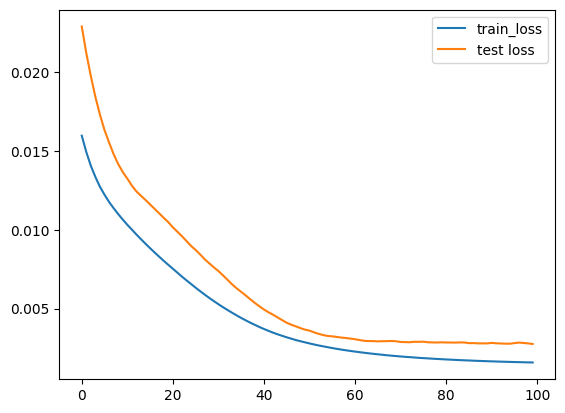

In [120]:
plt.plot(r.history['loss'],label = 'train_loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [121]:
PTrain = model.predict(XTrain_m)
PTest = model.predict(XTest_m)

1/1 [==============================] - 0s 20ms/step


In [122]:
PTrain.shape,PTest.shape

((121, 12), (1, 12))

In [123]:
#Only get the first value to avoid redundancy
# 1,2,3 - get 1
# 2,3,4 - get 2
# 3,4,5 - get 3
PTrain = PTrain[:,0]
PTest = PTest[0]

In [124]:
#Save multioutput forecast to dataframe
df.loc[test_idx,'multioutput'] = last_train + \
np.cumsum(PTest)

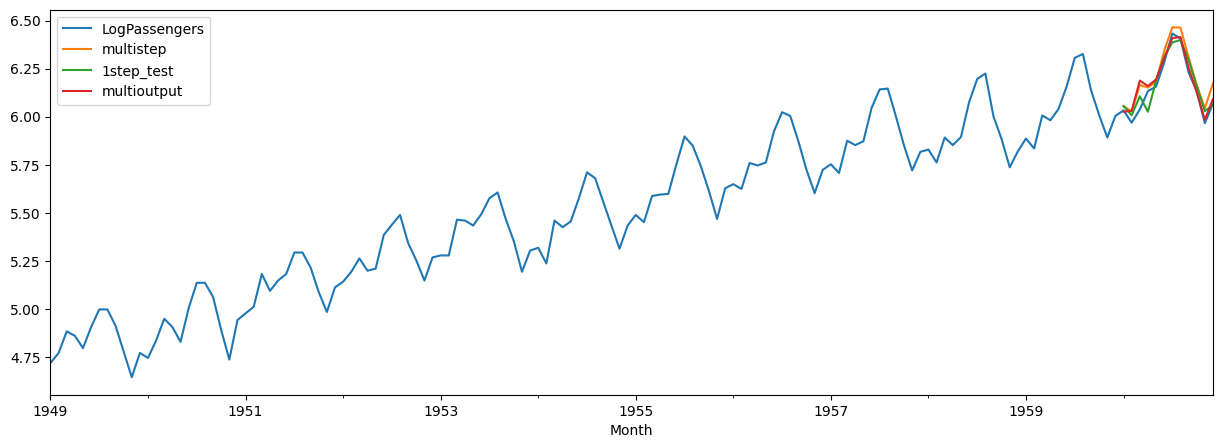

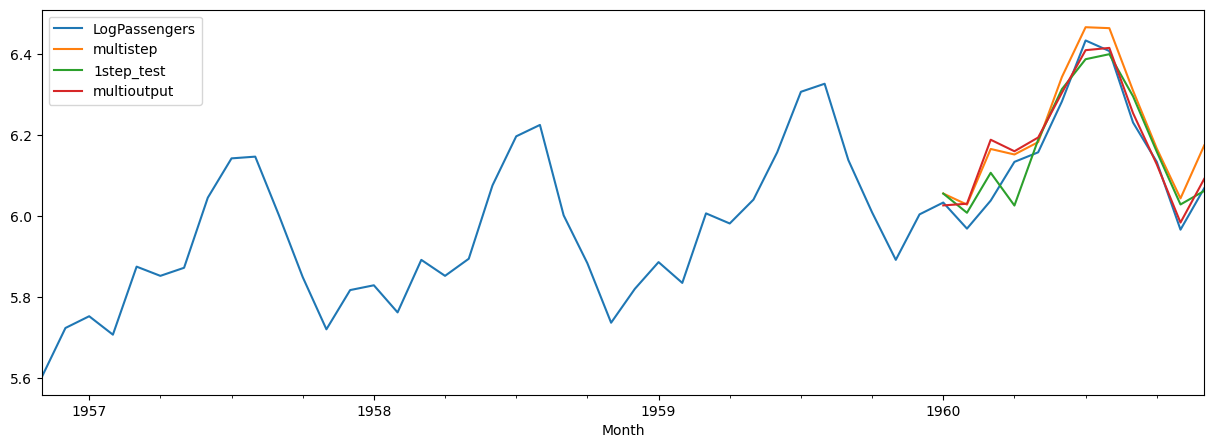

In [125]:
cols = [
    'LogPassengers',
    'multistep',
    '1step_test',
    'multioutput'
]
df[cols].plot(figsize = (15,5))
df.iloc[-50:][cols].plot(figsize = (15,5));

In [126]:
#MAPE
test_log_pass = df.iloc[-NTest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multistep']
)
print('multi-step   MAPE: ',mape1)

mape2 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput']
)
print('multi-output MAPE: ',mape2)

multi-step   MAPE:  0.009463132015149728
multi-output MAPE:  0.005526561964213313
